# Topic Modeling

***
 <i> <b>This notebook contains the code for Topic modeling and Word Cloud, and it targets to identify What are the main topics of the tweets with the hashtag "#heatwave".</b></i> 
***

In [11]:
## Required packages
import pandas as pd # data manipulation
from sklearn.feature_extraction.text import TfidfVectorizer # Text Frequency - Inverse data Frequency model
import matplotlib.pyplot as plt
import numpy as np
import re  # Regular expressions (eliminate @ or undesired parts of the text)
import gdown # Download database from google drive
from nltk.corpus import stopwords # Eliminate meaningless words
import string # library to work with test
import nltk # Library for natural language processing
from nltk.tokenize import sent_tokenize, word_tokenize #Separete words or sentences
from sklearn.decomposition import LatentDirichletAllocation # Topic Modeling Algorithm
from nltk.stem import WordNetLemmatizer # Convert to root word
from nltk.corpus import wordnet #another lematization tool
from sklearn.model_selection import GridSearchCV # To test the model with multiple parameters
from wordcloud import WordCloud # 
from nltk.probability import FreqDist #

#### Loading dataset

In [44]:
# Packages to support lematization process
nltk.download('punkt') 
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ricar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ricar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ricar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ricar\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [114]:
# Download data
!gdown 1yu-YLNSOm9lBhaRY8hJHa5hz3bOZql7V

In [14]:
df = pd.read_json('heatwave.json', lines=True)
df.head(2)

,_id,source,lang,entities,context_annotations,conversation_id,attachments,id,text,author_id,created_at,public_metrics,in_reply_to_user_id,referenced_tweets,geo,withheld
0,{'$oid': '627188b089f0f3936420ea25'},Twitter Web App,en,"{'annotations': [{'start': 75, 'end': 83, 'pro...","[{'domain': {'id': '47', 'name': 'Brand', 'des...",1519939637179187200,{'media_keys': ['3_1519939627674894337']},1519939637179187200,#Heatwave | Yellow warning for 3 days - April ...,37034483,2022-04-29 07:20:23+00:00,"{'retweet_count': 7, 'reply_count': 2, 'like_c...",NaN,NaN,NaN,NaN
1,{'$oid': '627188b089f0f3936420ea26'},Twitter for Android,en,"{'annotations': [{'start': 0, 'end': 7, 'proba...",NaN,1519938836280786944,{'media_keys': ['3_1519938827133063170']},1519938836280786944,Pakistan was hotter than half of the world wit...,1420085660115996672,2022-04-29 07:17:12+00:00,"{'retweet_count': 44, 'reply_count': 7, 'like_...",NaN,NaN,NaN,NaN


#### Obtaining tweets with more than 20 likes (to get the ones with higher impact)

In [15]:
likes = list()

for idx, row in df.iterrows():
  dataset = row['public_metrics']
  likes.append(dataset['like_count'])

df['likes'] = likes

In [16]:
# Analyze tweets with more than 20 likes
new_sample = df[df['likes']>20].reset_index(drop=True)

##### Topic Modelin Required Preprocessing And Data Preparation

In [21]:
stopwords_en = set(stopwords.words('english'))
exclude = set(string.punctuation)

def clean_text(tweet):
  text = tweet.lower() # Lowercase
  text = re.sub("'", "", text) # to avoid removing contractions in english
  text = re.sub("@[A-Za-z0-9_]+","", text)
  text = re.sub("#[A-Za-z0-9_]+","", text)
  text = re.sub(r'http\S+', '', text) # remove links
  text = re.sub('[()!?]', ' ', text)
  text = re.sub('\[.*?\]',' ', text)
  text = re.sub("[^a-z0-9]"," ", text) # remove numbers
  text = re.sub(r'[0-9]+', '', text)   
  tweet = re.sub(r'\b\w{1,2}\b', '', text) # Remove words with 2 letters or less
  text = text.split()
  text = [w for w in text if not w in stopwords_en]
  text = [w for w in text if not w in exclude]
  text = " ".join(word for word in text) # remove parenthesis
  return text


In [28]:
new_sample['clean_text'] = [clean_text(tw) for tw in new_sample['text']]

In [33]:
new_sample['num_words_text'] = new_sample['clean_text'].apply(lambda x:len(str(x).split())) 
new_sample = new_sample[new_sample['num_words_text']>=3]

In [36]:
new_sample['clean_text_tokenize'] = new_sample['clean_text'].replace(r'heat wave','heatwave', regex=True)

In [31]:
new_sample['clean_text_tokenize'] = new_sample['clean_text'].replace(r'heat waves','heatwave', regex=True)

In [32]:
new_sample['clean_text_tokenize'] = new_sample['clean_text'].replace(r'heatwaves','heatwave', regex=True)

In [42]:
lemmatizer = WordNetLemmatizer()

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [46]:
#Required for lematization - next step
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ricar\AppData\Roaming\nltk_data...


True

In [47]:
text_lemmatized = list()
for sent in new_sample['clean_text']: 
    text_lemmatized.append(lemmatize_sentence(sent))

In [48]:
new_sample['clean_text_lemmatized'] = text_lemmatized

In [49]:
new_sample['clean_text_lemmatized_words'] = [word_tokenize(tw) for tw in new_sample['clean_text_lemmatized']]

In [51]:
new_sample['clean_text_lemmatized_words']

0        [yellow, warning, day, april, may, western, ra...
1        [pakistan, hotter, half, world, dadu, th, larg...
2                  [april, feel, like, june, megha, barso]
3        [india, reel, intense, heatwave, year, northwe...
4        [fierce, indian, temperature, part, bundelkhan...
                               ...                        
14307    [costa, del, barricane, love, hope, time, chil...
14308    [severe, condition, currently, affect, large, ...
14309    [severe, condition, across, country, know, sig...
14310    [first, day, back, hot, today, mark, day, part...
14311                               [drink, water, bottle]
Name: clean_text_lemmatized_words, Length: 13380, dtype: object

In [52]:
words_length_less_three = list()

for word in new_sample['clean_text_lemmatized']:
  t = word_tokenize(word)
  for word_1 in t:
    if len(word_1) <= 3: 
      words_length_less_three.append(word_1)

#pd.Series(words_length_less_three).value_counts()[0:50]

In [53]:
# Top 50 meaningless words
pd.Series(words_length_less_three).value_counts()[0:50]

hot    2535
c      2170
day    2056
amp    1543
get    1136
go      948
one     705
see     547
us      521
new     518
sun     513
f       448
ice     403
dog     387
may     376
say     374
uk      362
air     359
pm      355
set     354
way     337
hit     317
tip     305
car     301
th      277
im      255
pet     253
use     236
fan     224
try     215
top     207
big     196
end     195
put     192
low     185
let     185
run     183
far     182
due     180
two     171
lot     169
cat     169
bad     158
old     140
die     134
bit     126
ac      122
do      122
max     120
dry     116
dtype: int64

In [54]:
words_to_keep = ['us', 'uk', 'tip', 'fan', 'die', 'dry', 'sea']
words_length_less_three_1 = [words for words in words_length_less_three if not words in words_to_keep]
set_words_length_less_three = set(words_length_less_three_1)  

In [55]:
def rem_words_length_less_three(tweet):
  text = tweet.split()
  text = [w for w in text if not w in set_words_length_less_three]
  text = " ".join(word for word in text) # remove parenthesis
  return text

In [58]:
new_sample['clean_text_lemmatized_1'] = [rem_words_length_less_three(tw) for tw in new_sample['clean_text_lemmatized']]

In [59]:
new_sample['clean_text_lemmatized_1']

0        yellow warning april western rajasthan punjab ...
1        pakistan hotter half world dadu large city sin...
2                         april feel like june megha barso
3        india reel intense heatwave year northwest ind...
4        fierce indian temperature part bundelkhand reg...
                               ...                        
14307    costa barricane love hope time chill enjoy dev...
14308    severe condition currently affect large part c...
14309    severe condition across country know sign heat...
14310    first back today mark part outback include tro...
14311                                   drink water bottle
Name: clean_text_lemmatized_1, Length: 13380, dtype: object

In [60]:
new_sample['clean_text_lemmatized_words_1'] = [word_tokenize(word) for word in new_sample['clean_text_lemmatized_1']]

In [61]:
new_sample['clean_text_lemmatized_words_1']

0        [yellow, warning, april, western, rajasthan, p...
1        [pakistan, hotter, half, world, dadu, large, c...
2                  [april, feel, like, june, megha, barso]
3        [india, reel, intense, heatwave, year, northwe...
4        [fierce, indian, temperature, part, bundelkhan...
                               ...                        
14307    [costa, barricane, love, hope, time, chill, en...
14308    [severe, condition, currently, affect, large, ...
14309    [severe, condition, across, country, know, sig...
14310    [first, back, today, mark, part, outback, incl...
14311                               [drink, water, bottle]
Name: clean_text_lemmatized_words_1, Length: 13380, dtype: object

In [62]:
bigram = nltk.collocations.BigramAssocMeasures()

In [69]:
bigram_finder = nltk.collocations.BigramCollocationFinder.from_documents([comment.split() for comment in  new_sample['clean_text_lemmatized_1'] ])

In [64]:
bigram_finder.apply_freq_filter(50)

In [65]:
bigram_scores = bigram_finder.score_ngrams(bigram.pmi)

In [71]:
bigram_dataframe = pd.DataFrame(bigram_scores)
bigram_dataframe.columns = ['bigram', 'pmi']
bigram_dataframe.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)
bigram_dataframe.head(2)

,bigram,pmi
0,"(pacific, northwest)",9.990432
1,"(land, surface)",9.738539


In [72]:
trigram = nltk.collocations.TrigramAssocMeasures()

In [73]:
trigram_finder = nltk.collocations.TrigramCollocationFinder.from_documents([comment.split() for comment in new_sample['clean_text_lemmatized_1'] ])
# Filter only those that occur at least 50 times
trigram_finder.apply_freq_filter(50)
trigram_scores = trigram_finder.score_ngrams(trigram.pmi)
trigram_scores

[(('ever', 'ever', 'ever'), 15.526012035448293)]

In [74]:
# Example filter for noun-type structures bigrams
def bigram_filter_noun(bigram):
    tag = nltk.pos_tag(bigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']:
        return False
    if bigram[0] in stopwords_en or bigram[1] in stopwords_en:
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    if 'PRON' in bigram:
        return False
    return True
# Can eyeball list and choose PMI threshold where n-grams stop making sense
# In this case, get top 500 bigrams/trigrams with highest PMI score
bigram_filtered = bigram_dataframe[bigram_dataframe.apply(lambda bigram: bigram_filter_noun(bigram['bigram']) 
                                                              and bigram.pmi > 1, axis = 1)][:500]
bigrams = [' '.join(x) for x in bigram_filtered.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]

In [76]:
# Concatenate n-grams
def replace_ngram(x):
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x

In [77]:
new_sample['clean_text_lemmatized_2'] = new_sample['clean_text_lemmatized_1'].map(lambda x: replace_ngram(x))

In [78]:
new_sample['clean_text_lemmatized_2_words'] = new_sample['clean_text_lemmatized_2'].map(lambda x: [word for word in x.split()])

In [80]:
words_to_remove = set(['heatwave'])
def remove_words(tweet): 
  text = [tw for tw in tweet if not tw in words_to_remove] 
  return text
new_sample['clean_text_lemmatized_3_words'] = [remove_words(tw) for tw in new_sample['clean_text_lemmatized_2_words']]

In [81]:
def noun_only(x):
    pos_comment = nltk.pos_tag(x)
    filtered = [word[0] for word in pos_comment if word[1] in ['NN']]
    return filtered

In [82]:
new_sample['clean_text_lemmatized_4_noun_words'] = new_sample['clean_text_lemmatized_3_words'].map(noun_only)

In [83]:
def word_to_sentence(x):
    tweet = " ".join(word for word in x) # remove parenthesis
    return tweet

In [84]:
new_sample['clean_text_lemmatized_3_noun'] = new_sample['clean_text_lemmatized_4_noun_words'].map(word_to_sentence)

In [85]:
new_sample['len_clean_text_lemmatized_3_noun'] = [len(x) for x in new_sample['clean_text_lemmatized_3_noun'] ]

In [86]:
new_sample_1 = new_sample[(new_sample['len_clean_text_lemmatized_3_noun'] >=2)]

In [87]:
new_sample_1['clean_text_lemmatized_3_noun']

0        warning april rajasthan punjab haryana delhi p...
1        hotter half world city sindh province experien...
2                                         june megha barso
3                  india reel year india record march year
4        temperature part bundelkhand region reach afte...
                               ...                        
14307                costa barricane hope time chill photo
14308    condition part australia burst heat forecast s...
14309      condition country sign heat heat someone suffer
14310                     today mark part tropical weekend
14311                                   drink_water bottle
Name: clean_text_lemmatized_3_noun, Length: 13111, dtype: object

##### TF-IDF and Latent Dirichlet Allocation parameter tuning


In [93]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.80, min_df=10,stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(new_sample_1['clean_text_lemmatized_3_noun'] )
df0 = pd.DataFrame(tfidf_matrix.toarray())
tfid_feature_names = tfidf_vectorizer.get_feature_names_out()
df0.columns = tfid_feature_names
df0

,absolute,access,accord,account,action,activity,addition,adult,advance,advice,...,yard,yeah,year,yesterday,york,yorkshire,youre,youtube,youve,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.325418,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.486713,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
#Topic Modeling 
params = {'n_components': [3,4,5,6], 'learning_decay': [.5,.7]}
# Init the Model
lda = LatentDirichletAllocation(random_state=0)
# Init Grid Search Class
model = GridSearchCV(lda, param_grid=params)

In [95]:
%%time
model.fit(tfidf_matrix)

CPU times: total: 9min 41s
Wall time: 9min 41s


GridSearchCV(estimator=LatentDirichletAllocation(random_state=0),
             param_grid={'learning_decay': [0.5, 0.7],
                         'n_components': [3, 4, 5, 6]})

##### LDA 

In [96]:
# Best Model
best_lda_model = model.best_estimator_
best_lda_model

LatentDirichletAllocation(learning_decay=0.5, n_components=3, random_state=0)

In [99]:
# Model Parameters
print("Best Model's Params: ", model.best_params_)
# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)
# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(tfidf_matrix))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 3}
Best Log Likelihood Score:  -35714.454630122615
Model Perplexity:  990.7542221547081


In [101]:
n_top_words = 15

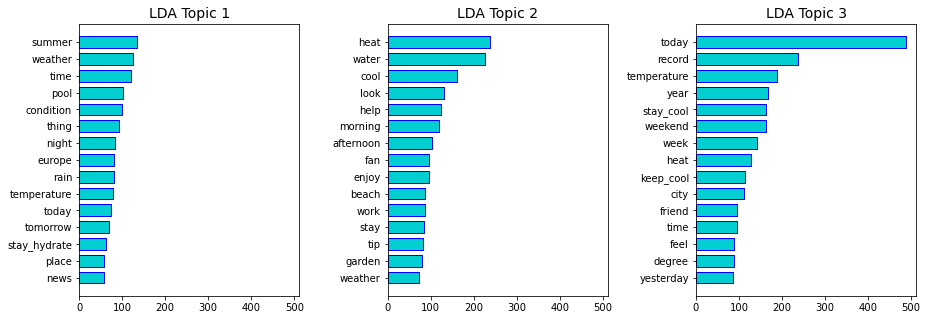

In [104]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)
axes = axes.flatten()

plt.subplots_adjust(wspace=0.4)

for topic_idx, topic in enumerate(model.best_estimator_.components_):
    top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
    top_features = [tfid_feature_names[i] for i in top_features_ind]
    weights = topic[top_features_ind]

    ax = axes[topic_idx]
    ax.barh(top_features, weights, height=0.7, color='darkturquoise', edgecolor='blue')
    ax.set_title(f'LDA Topic {topic_idx +1}',
                     fontdict={'fontsize': 14})
    ax.invert_yaxis()
    ax.tick_params(axis='both', which='major', labelsize=10)

By looking at the top 15 words of each topic it can be inferred that the three topics are about Recreational Activities ('summer', 'weather', 'time', 'pool'), Tips('heat', 'water', 'cool', 'look'), and High Temperatures ('today', 'record', 'temperature', 'year'). Thus, we can give the tweets the topic name with the higher probability of one of these topics. 

In [103]:
# Create Document — Topic Matrix
lda_output = best_lda_model.transform(tfidf_matrix)
# column names
topicnames = ['Topic' + str(i) for i in range(best_lda_model.n_components)]
# index names
docnames = ['Doc' + str(i) for i in range(len(new_sample_1['clean_text_lemmatized_3_noun'] ))]
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

In [105]:
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

In [106]:
new_sample_2 = pd.concat([new_sample_1.reset_index(),df_document_topic.reset_index(drop=True)],axis =1 ) 

In [107]:
df_document_topic['dominant_topic'].value_counts()

2    4412
0    4390
1    4309
Name: dominant_topic, dtype: int64

In [108]:
health_vector = ['mortality', 'health', 'dead', 'die']
health_vector

['mortality', 'health', 'dead', 'die']

In [109]:
sample_health = new_sample_2[new_sample_2.text.str.contains('|'.join(health_vector ))]

In [110]:
len(sample_health)/len(new_sample_2)

0.03600030508733125

##### Wordcould 

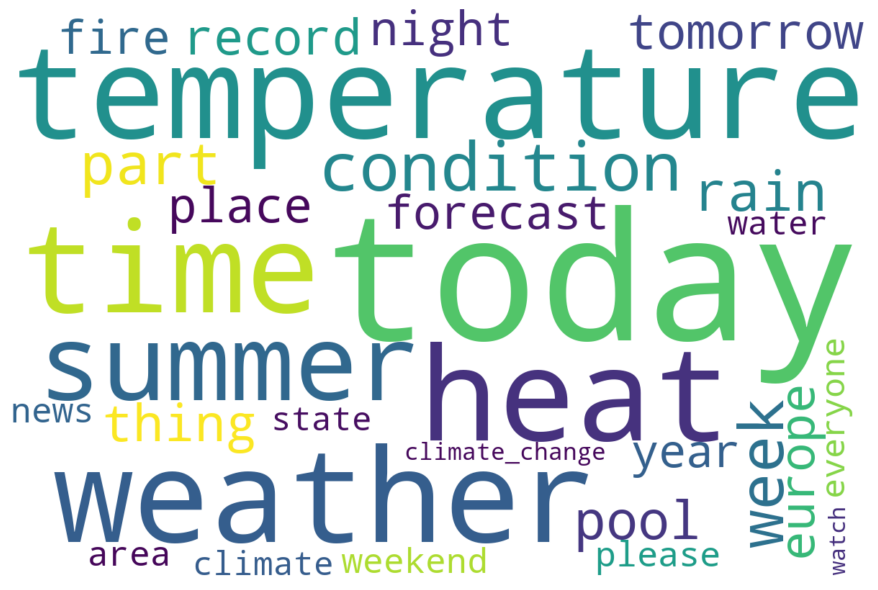

In [111]:
flat_words_0 = [item for sublist in new_sample_2[new_sample_2['dominant_topic']==0]['clean_text_lemmatized_4_noun_words'] for item in sublist]
word_freq = FreqDist(flat_words_0)
most_common_count = [x[1] for x in word_freq.most_common(30)]
most_common_word = [x[0] for x in word_freq.most_common(30)]
top_100_dictionary = dict(zip(most_common_word, most_common_count))
wordcloud = WordCloud(background_color = 'white', width=1200, height=800)\
.generate_from_frequencies(top_100_dictionary)

#plot with matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

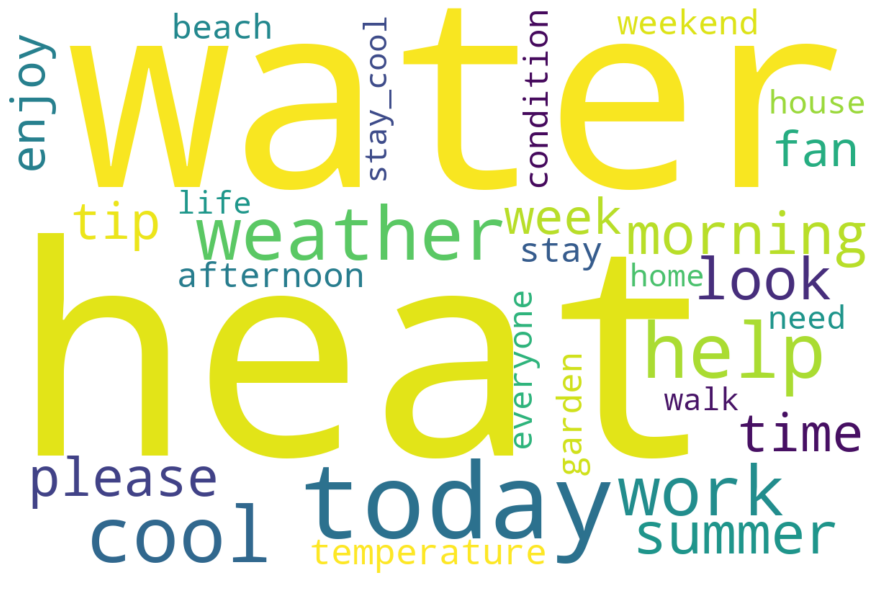

In [112]:
flat_words_1 = [item for sublist in new_sample_2[new_sample_2['dominant_topic']==1]['clean_text_lemmatized_4_noun_words'] for item in sublist]
word_freq = FreqDist(flat_words_1)
most_common_count = [x[1] for x in word_freq.most_common(30)]
most_common_word = [x[0] for x in word_freq.most_common(30)]
top_100_dictionary = dict(zip(most_common_word, most_common_count))
wordcloud = WordCloud(background_color = 'white', width=1200, height=800)\
.generate_from_frequencies(top_100_dictionary)

#plot with matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

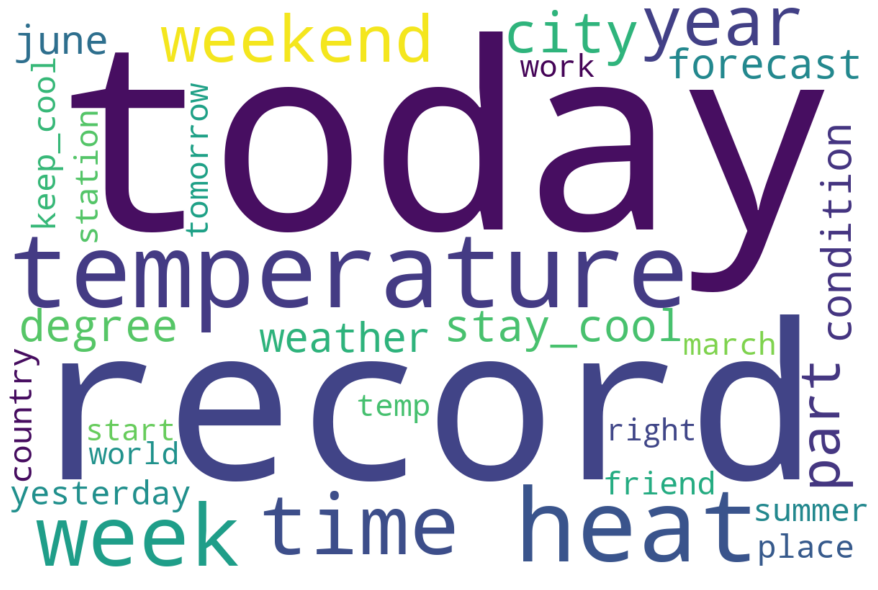

In [113]:
flat_words_2 = [item for sublist in new_sample_2[new_sample_2['dominant_topic']==2]['clean_text_lemmatized_4_noun_words'] for item in sublist]
word_freq = FreqDist(flat_words_2)
most_common_count = [x[1] for x in word_freq.most_common(30)]
most_common_word = [x[0] for x in word_freq.most_common(30)]
top_100_dictionary = dict(zip(most_common_word, most_common_count))
wordcloud = WordCloud(background_color = 'white', width=1200, height=800)\
.generate_from_frequencies(top_100_dictionary)

#plot with matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()